In [78]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import FloatProgress
from IPython.display import display

In [103]:
# Set default plot settings
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'medium'
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['savefig.facecolor']='white'

# Question 2

## a)

In [44]:
# Euclidean distance
def dist(xi, mj):
    return np.linalg.norm(xi - mj, axis=1)

def kmeans(data, k, pp=False):
    n_points = len(data)
    n_dim = data.shape[1]
    
    # Random initialization of centroids and scaling to fall within range of data
    if not pp:
        centers = np.random.rand(k, n_dim)
        for l in xrange(n_dim):
            centers[:,l] = centers[:,l]*(data[:,l].max()-data[:,l].min()) - abs(data[:,l].min())
    # Else, use k-means++ seeding
    else:
        centers = np.zeros((k, n_dim))
        # First centroid chosen uniformly at random from x
        centers[0] = data[np.random.randint(n_points)]

        for i in xrange(1, k):
            # Get distance to nearest existing cluster center for all points
            distances = np.zeros((n_points, i))
            for p in xrange(i):
                distances[:, p] = dist(data, centers[p])  
            d_imin1 = distances.min(axis=1)

            # Select new centroid based on the probability constructed from the nearest
            # distances
            prob = d_imin1**2/np.sum((d_imin1)**2)
            centers[i] = data[np.random.choice(n_points, p=prob)]
    
    labels = np.zeros(len(data), dtype="int32")
    distortion = []
    unconverged = True
    while unconverged:
        distortion.append(0.)
        for i, xi in enumerate(data):
            # Update assignments
            distances = dist(xi, centers)
            labels[i] = np.argmin(distances)
            
            # Calc avg square dist distortion
            distortion[-1] += distances[labels[i]]**2
        
        # Update centroids
        c_update = np.zeros((k, n_dim))
        for j in xrange(k):
            # Keep previous centroid if no points assigned
            if j in labels:
                xinCj = data[np.where(labels==j)]
                c_update[j] = xinCj.mean(axis=0)
            else:
                c_update[j] = centers[j]
        if np.all(np.isclose(c_update, centers)):
            unconverged = False
        else:
            centers = c_update 
       
    return {"centers": centers, "labels": labels, "distortion": distortion}

Run k-means for 20 trials and plot the distortion:

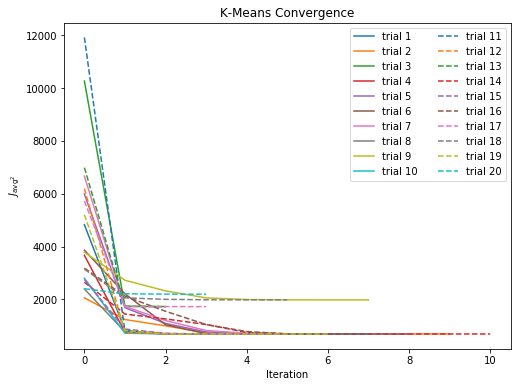

In [45]:
# Load data
fn = "toydata.txt"
data = np.loadtxt(fn)

# Run k-means
n_trials = 20
trials = []
for i in xrange(n_trials):
    trials.append(kmeans(data, 3))

# Plot distortion
ls = ['-', '--']
fig0 = plt.figure(figsize=(8,6), facecolor='w')
for i in xrange(n_trials):
    plt.plot(range(len(trials[i]["distortion"])), trials[i]["distortion"],
             linestyle=ls[(i/10)], label="trial %d" % (i+1))
plt.xlabel("Iteration")
plt.ylabel("$J_{\mathrm{avg}^2}$")
plt.title("K-Means Convergence")
plt.legend(loc='best', ncol=2)
plt.show()

The figure above shows that the algorithm usually converges within 5 steps for the toy data set. However, it gets trapped in different local minimum inidicated by the different final $J_{\mathrm{avg}^2}$ values, depending on the initial centroid values.

Plot the final clustering for a run that achieved a low distortion:

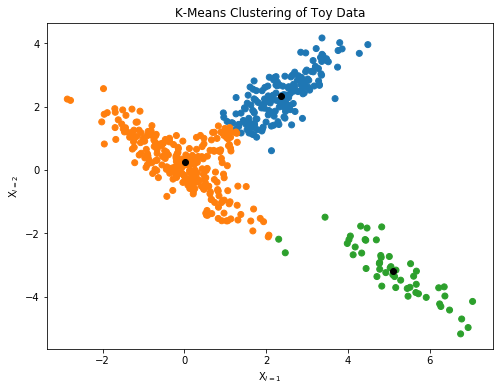

In [46]:
sele = 10
centers = trials[sele]["centers"]
labels = trials[sele]["labels"] 
colors = ['C%i' % (i % 10) for i in labels]

fig0 = plt.figure(figsize=(8,6), facecolor='w')
plt.scatter(data[:,0], data[:,1], c=colors)
plt.scatter(centers[:,0], centers[:,1], c='k')
plt.xlabel("X$_{l=1}$")
plt.ylabel("X$_{l=2}$")
plt.title("K-Means Clustering of Toy Data")
plt.show()

## b)

K-means seeding was added as an option to the original algorithm above

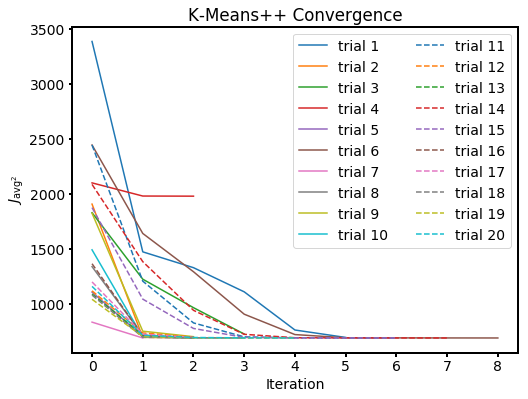

In [131]:
n_trials = 20
trials = []
for i in xrange(n_trials):
    trials.append(kmeans(data, 3, pp=True))

# Plot distortion
ls = ['-', '--']
fig0 = plt.figure(figsize=(8,6), facecolor='w')
for i in xrange(n_trials):
    plt.plot(range(len(trials[i]["distortion"])), trials[i]["distortion"],
             linestyle=ls[(i/10)], label="trial %d" % (i+1))
plt.xlabel("Iteration")
plt.ylabel("$J_{\mathrm{avg}^2}$")
plt.title("K-Means++ Convergence")
plt.legend(loc='best', ncol=2)
plt.show()

The figure above shows how the trials generally start at a lower $J_{\mathrm{avg}^2}$ value and how more trials have reached convergence to a low $J_{\mathrm{avg}^2}$ value with k-means++ seeding compared to the original uniform random seeding.  

# Question 3

In [101]:
def gmm_em(data, k):
    n_points = len(data)
    n_dim = data.shape[1]
    
    # Initialize parameters
    pi = np.ones(k)*1/k # equally likely
    mu = np.random.rand(k, n_dim)
    for l in xrange(n_dim):
        mu[:,l] = mu[:,l]*(data[:,l].max()-data[:,l].min()) - abs(data[:,l].min())
    sigma = [np.eye(n_dim) for j in xrange(k)] # circular
    
    labels = np.zeros(len(data), dtype="int32")
    l_theta = [] # log-likelihood
    unconverged = True
    while unconverged:
        l_theta.append(0.)
        
        ## Expectation: Given params, update assignments
        # Find prob that points came from each Gaussain component
        # and assign to the one with the highest prob
        prob = np.ones((n_points, k))
        for j in xrange(k):
            prob[:,j] *= pi[j]*multivariate_normal.pdf(data, mean=mu[j], cov=sigma[j])
        labels = np.argmax(prob, axis=1)
        
        # Calculate log-likelihood
        l_theta[-1] = np.sum(np.log(prob.sum(axis=1)))
        
#         # Check convergence
#         if len(l_theta) > 1 and np.isclose(l_theta[-1], l_theta[-2], rtol=1e-15, atol=1e-18):
#             break

        # Maximization: Given assignments, update params
        mu_update = np.zeros((k, n_dim))
        for j in xrange(k):
            # Responsibilities
            pij = prob[:,j] / prob.sum(axis=1)
            pij_sum = pij.sum()

            pi[j] = pij_sum / float(n_points)
            mu_update[j] = np.sum(pij[:, None]*data, axis=0)/pij_sum
            sig_update = np.zeros((n_dim, n_dim))
            for i, x in enumerate(data): 
                sig_update += pij[i]*np.outer(x-mu_update[j], x-mu_update[j])
            sig_update /= pij_sum
            sigma[j] = sig_update
        # Check convergence of mu to be comparable to k-means
        if np.all(np.isclose(mu_update, mu)):
            unconverged = False
        else:
            mu = mu_update
        
    return {"mu": mu, "labels": labels, "l_theta": l_theta}

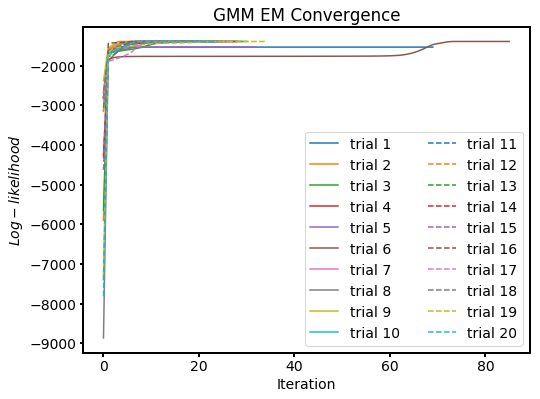

In [104]:
# Load data
fn = "toydata.txt"
data = np.loadtxt(fn)

# Run gmm EM
n_trials = 20
trials = []
for i in xrange(n_trials):
    trials.append(gmm_em(data, 3))

# Plot distortion
ls = ['-', '--']
fig0 = plt.figure(figsize=(8,6), facecolor='w')
for i in xrange(n_trials):
    plt.plot(range(len(trials[i]["l_theta"])), trials[i]["l_theta"],
             linestyle=ls[(i/10)], label="trial %d" % (i+1))
plt.xlabel("Iteration")
plt.ylabel("$Log-likelihood$")
plt.title("GMM EM Convergence")
plt.legend(loc='best', ncol=2)
plt.show()

The figure above shows how the GMM EM method generally requires more iterations (>20) for convergence compared to k-means. Some trials are trapped in the local minima of lower likelihood states.   

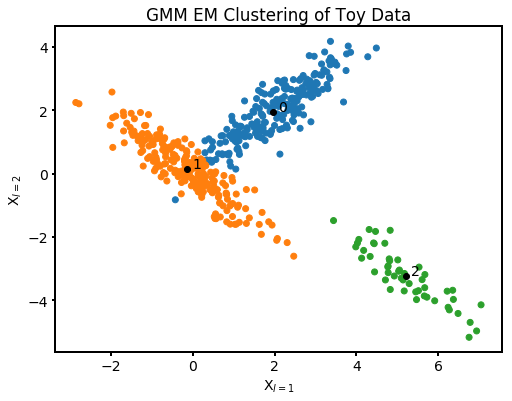

In [108]:
sele = 5
centers = trials[sele]["mu"]
labels = trials[sele]["labels"] 
colors = ['C%i' % (i % 10) for i in labels]

fig0 = plt.figure(figsize=(8,6), facecolor='w')
plt.scatter(data[:,0], data[:,1], c=colors)
plt.scatter(centers[:,0], centers[:,1], c='k')
for j in xrange(3):
    plt.annotate(j, (centers[j, 0], centers[j, 1]), xytext=(5, 5), textcoords='offset points', va='center')
plt.xlabel("X$_{l=1}$")
plt.ylabel("X$_{l=2}$")
plt.title("GMM EM Clustering of Toy Data")
plt.show()

The figure above shows how the clusters are elipsoidal in shape, with the skew determined by the $\Sigma$, whereas with kmeans there was more irregularity. You may notice that there is a point belonging to cluster 0, but is found beyond cluster 1. This is due to the underlying Gaussian for cluster 0 having a larger variance in this direction, such that it is more likely for the point to belong to it. 